In [1]:
# 사용 패키지
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 데이터 로드
data = pd.read_csv("/content/drive/MyDrive/시계열프로젝트/한국가스공사_시간별 공급량_20181231 (1).csv",
                   encoding='cp949')

# 데이터 모형 확인
data.shape

(368088, 4)

# 데이터 분석

In [3]:
# 결측치 및 데이터 타입 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368088 entries, 0 to 368087
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   연월일     368088 non-null  object 
 1   시간      368088 non-null  int64  
 2   구분      368088 non-null  object 
 3   공급량     368088 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 11.2+ MB


In [4]:
data.head()

,연월일,시간,구분,공급량
0,2013-01-01,1,A,2497.129
1,2013-01-01,2,A,2363.265
2,2013-01-01,3,A,2258.505
3,2013-01-01,4,A,2243.969
4,2013-01-01,5,A,2344.105


In [5]:
# '구분' 종류 파악
data['구분'].unique()

array(['A', 'B', 'C', 'D', 'E', 'G', 'H'], dtype=object)

In [6]:
data['연월일'] = pd.to_datetime(data['연월일'])

In [7]:
data['year'] = data['연월일'].dt.year
data['month'] = data['연월일'].dt.month
data['day'] = data['연월일'].dt.day

In [8]:
data_d = data.groupby(['year', 'month'],as_index=False)['공급량'].sum().round()
data_d  # series타입

,year,month,공급량
0,2013,1,10438957.0
1,2013,2,8287286.0
2,2013,3,6683424.0
3,2013,4,5043240.0
4,2013,5,3124908.0
...,...,...,...
67,2018,8,2459351.0
68,2018,9,2490485.0
69,2018,10,4002205.0
70,2018,11,5703250.0


In [9]:
# train, test set 나누기

train = data_d[data_d.year!=2018]
test = data_d[data_d.year==2018]
test

,year,month,공급량
60,2018,1,10625219.0
61,2018,2,8800432.0
62,2018,3,6254202.0
63,2018,4,4208574.0
64,2018,5,3172389.0
65,2018,6,2637862.0
66,2018,7,2589802.0
67,2018,8,2459351.0
68,2018,9,2490485.0
69,2018,10,4002205.0


In [10]:
'''# test set index 맞추기
test.reset_index(inplace=True)
test.drop(['index'], axis=1, inplace=True)
test'''

"# test set index 맞추기\ntest.reset_index(inplace=True)\ntest.drop(['index'], axis=1, inplace=True)\ntest"

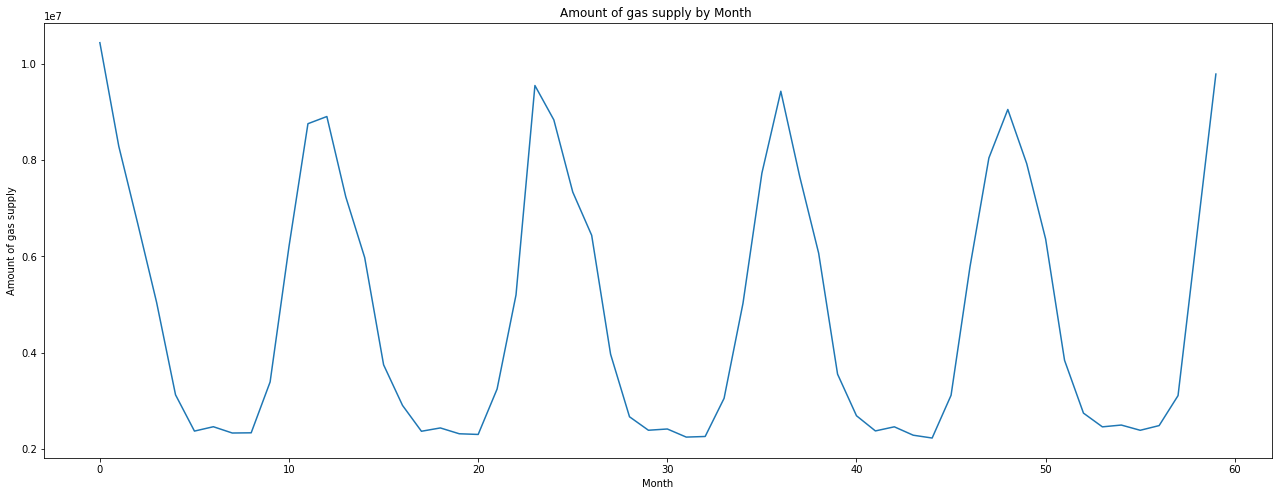

In [11]:
plt.figure(figsize=(22,8))
plt.plot(train['공급량'])
plt.title("Amount of gas supply by Month ")
plt.xlabel("Month")
plt.ylabel("Amount of gas supply")
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<Figure size 432x288 with 0 Axes>

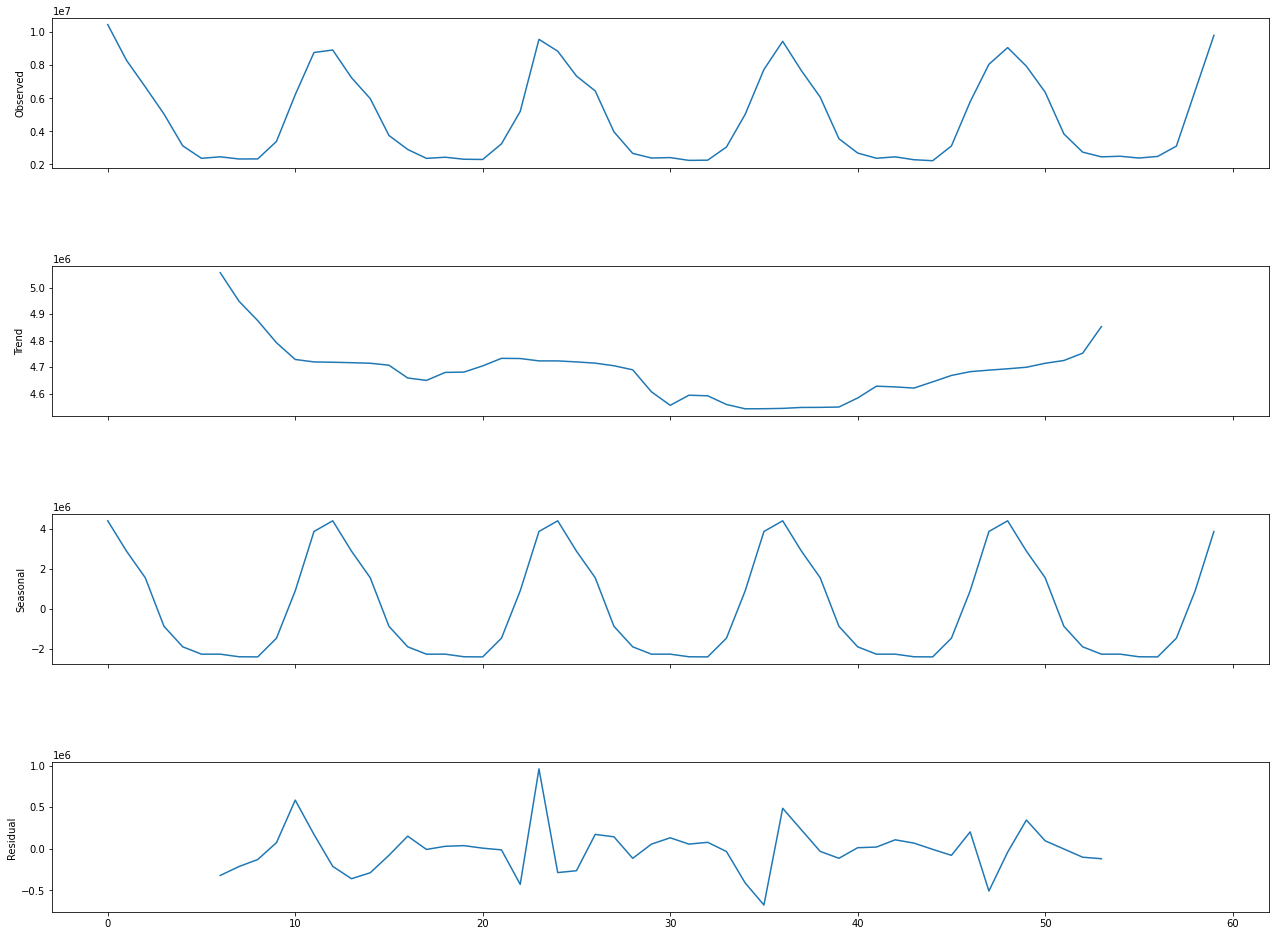

In [12]:
# 시계열 분해법?
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train['공급량'], model='additive', freq=12)

fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,15)

데이터에 패턴이 보이므로 정상성이 의심된다. 이를 판단하기 위해 ACF 그래프를 그려보자.


(시계열분해법 해석 적기)

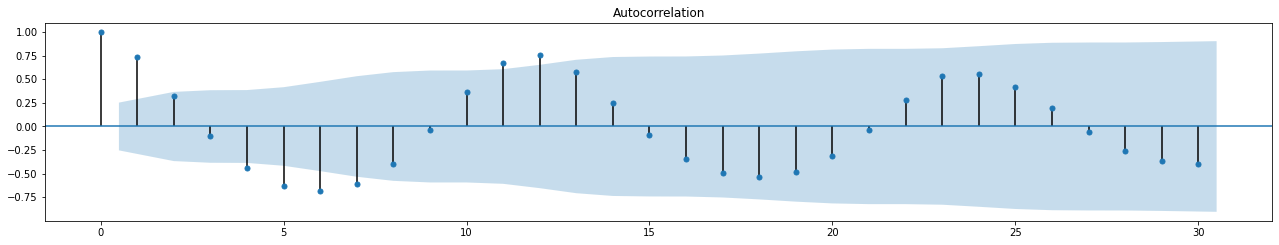

In [13]:
import statsmodels.api as sm

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train['공급량'], lags=30, ax=ax1)


단위근 검정인 ADF검정으로 정상성을 확인해보자.
이 검정의 가설은
> H0(귀무가설) : 자료에 단위근이 존재한다. 즉, 정상성을 만족하지 않는다.
<BR> H1(대립가설) : 자료가 정상성을 만족한다.

In [14]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train['공급량'])
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
print("Critical Values: ")
for key, value in result[4].items():
  print('\t%s: %.3f' % (key,value))

ADF Statistic: -2.785878
p-value: 0.060319
Critical Values: 
	1%: -3.575
	5%: -2.924
	10%: -2.600


p-value가 0.05를 넘으므로 귀무가설을 기각하지 못한다. 즉, 정상성을 만족하지 못한다.

1차 차분을 해주자.

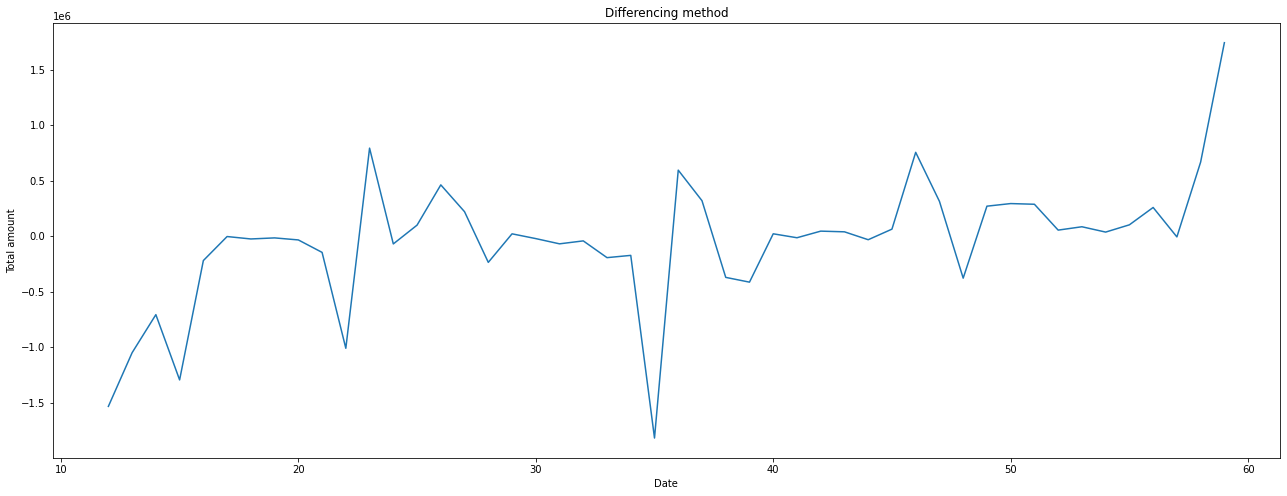

In [15]:
# 계절 차분
train_diff1 = train['공급량'] - train['공급량'].shift(12)
plt.figure(figsize=(22,8))
plt.plot(train_diff1)
plt.title("Differencing method")
plt.xlabel("Date")
plt.ylabel("Total amount")
plt.show()

랜덤한 경향을 보이므로 한번 더 차분 해주도록 하자.

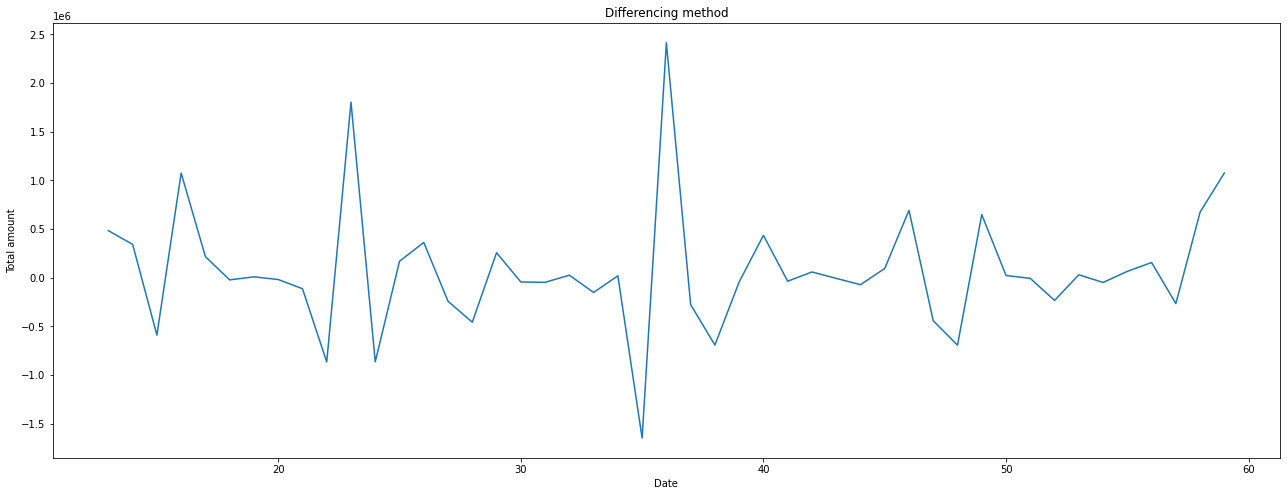

In [16]:
# 추가 차분
train_diff2 = train_diff1 - train_diff1.shift()
plt.figure(figsize=(22,8))
plt.plot(train_diff2)
plt.title("Differencing method")
plt.xlabel("Date")
plt.ylabel("Total amount")
plt.show()

차분한 데이터로 ADF 검정 결과를 다시 구해보자.

In [17]:
train_diff2

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6           NaN
7           NaN
8           NaN
9           NaN
10          NaN
11          NaN
12          NaN
13     483722.0
14     342694.0
15    -587851.0
16    1075253.0
17     216383.0
18     -21771.0
19       9553.0
20     -18299.0
21    -112263.0
22    -863936.0
23    1803174.0
24    -862988.0
25     169257.0
26     362744.0
27    -241702.0
28    -456374.0
29     257082.0
30     -43005.0
31     -47181.0
32      26548.0
33    -150969.0
34      20365.0
35   -1645579.0
36    2413489.0
37    -275301.0
38    -690753.0
39     -42956.0
40     435551.0
41     -35542.0
42      59529.0
43      -6134.0
44     -71197.0
45      95330.0
46     692037.0
47    -441510.0
48    -692028.0
49     648429.0
50      23438.0
51      -6170.0
52    -232984.0
53      30281.0
54     -48080.0
55      65515.0
56     156301.0
57    -265253.0
58     674071.0
59    1075800.0
Name: 공급량, dtype: float64

In [18]:
train_diff2 = train_diff2.dropna()

result = adfuller(train_diff2)
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
print("Critical Values: ")
for key, value in result[4].items():
  print('\t%s: %.3f' % (key,value))

ADF Statistic: -5.801350
p-value: 0.000000
Critical Values: 
	1%: -3.589
	5%: -2.930
	10%: -2.603


p-value가 0.05보다 작으므로 귀무가설을 기각한다. 즉, 차분한 데이터는 정상성을 만족한다.

정상성을 만족하는 데이터로 ACF와 PACF 그래프를 그려 ARIMA 모형의 p,q를 결정해보자.

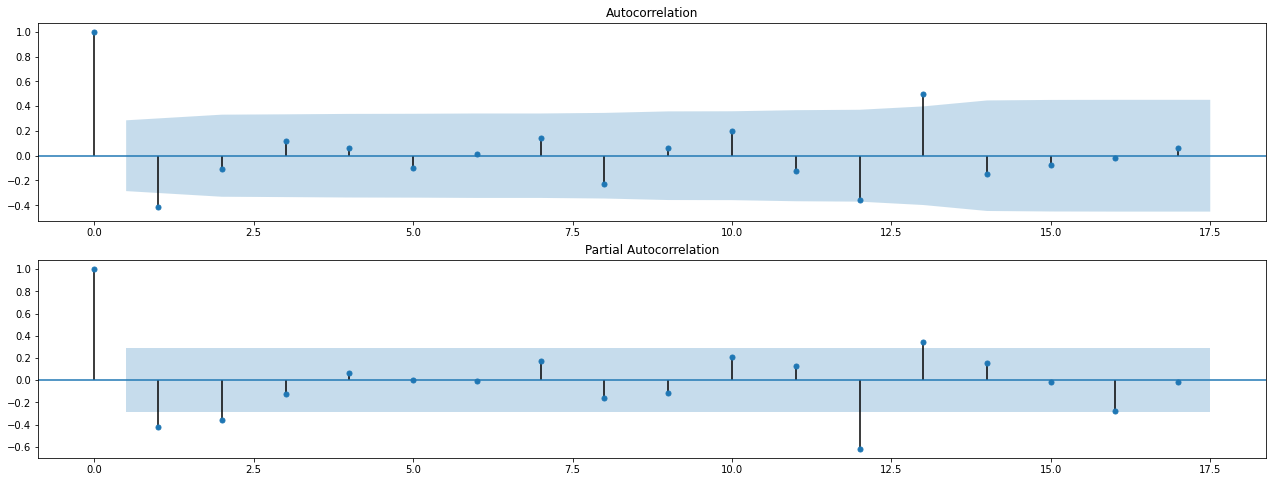

In [19]:
# 차분 후 acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(train_diff2, ax = ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(train_diff2, ax = ax2)

# 모형구축

AIC를 기준으로 최적의 차수를 정해보자

In [22]:
from statsmodels.tsa.arima_model import ARIMA

def my_auto_arima(data, order, sort='AIC'):
  order_list = []
  aic_list = []
  for p in range(order[0]):
    for d in range(order[1]):
      for q in range(order[2]):
        model = ARIMA(data, order=(p,d,q))
        
        try:
          model_fit = model.fit()
          c_order = f'p{p} d{d} q{q}'
          aic = model_fit.aic
          order_list.append(c_order)
          aic_list.append(aic)
        
        except:
          pass
  result_df = pd.DataFrame(list(zip(order_list, aic_list)),columns=['order','AIC'])
  result_df.sort_values(sort, inplace=True)
  return result_df

In [23]:
my_auto_arima(train_diff2, [3,3,3])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was pro

,order,AIC
18,p2 d2 q2,1339.785814
16,p2 d1 q1,1360.351535
4,p0 d1 q1,1372.131411
1,p0 d0 q1,1378.619136
15,p2 d1 q0,1379.898170
8,p1 d0 q1,1380.520411
2,p0 d0 q2,1380.525365
12,p2 d0 q0,1381.585401
13,p2 d0 q1,1381.921792
9,p1 d0 q2,1382.680326


ARIMA(2,2,2)가 최적의 모델임을 확인 할 수 있다. 
실제 모델의 fitting 결과를 확인해보자.

In [24]:
# fit model ARIMA

model = ARIMA(train_diff2, order=(2,2,2))
model_fit = model.fit()
model_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D2.공급량   No. Observations:                   45
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -663.893
Method:                       css-mle   S.D. of innovations         525902.857
Date:                Wed, 24 Nov 2021   AIC                           1339.786
Time:                        07:57:29   BIC                           1350.626
Sample:                             2   HQIC                          1343.827
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          895.6643    432.240      2.072      0.045      48.489    1742.839
ar.L1.D2.공급량    -0.6402      0.142     -4.516      0.000      -0.918      -0.362
ar.L2.D2.공급량    -0.4139      0.140     -2.956      0.005      -0.688      -0.139
ma.L1.D2.공급량    -1.9908      0.101    -19.768      0.000      -2.188      -1.793
ma.L2.D2.공급량     0.9981      0.101      9.916      0.000       0.801       1.195
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.7735           -1.3483j            1.5544           -0.3329
AR.2           -0.7735           +1.3483j            1.5544            0.3329
MA.1            0.9972           -0.0859j            1.0009           -0.0137
MA.2            0.9972           +0.0859j            1.0009            0.0137
-----------------------------------------------------------------------------
"""

#예측

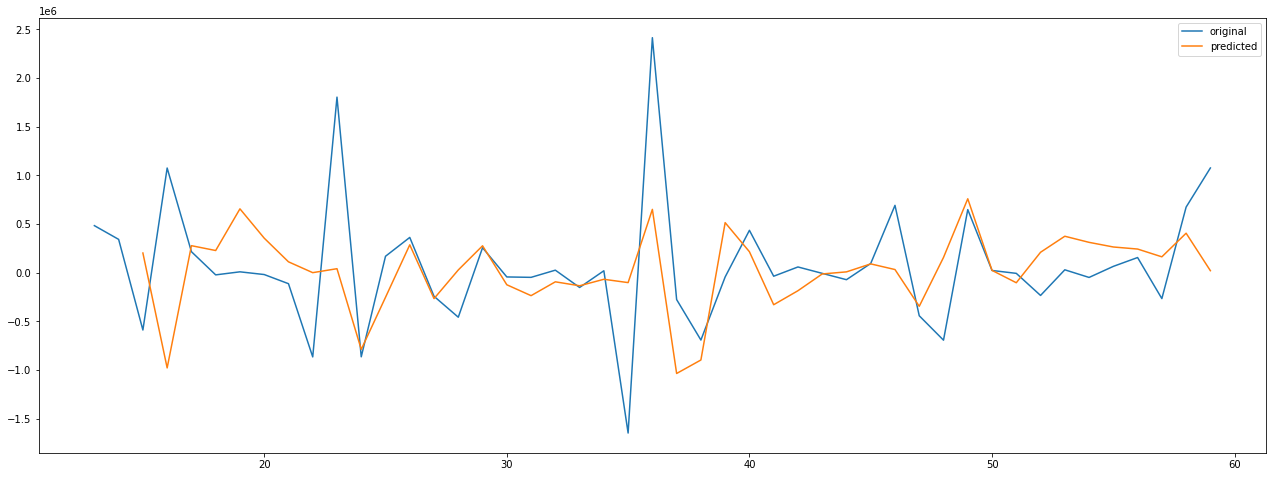

In [25]:
# predict
forecast = model_fit.predict(typ='levels')

# show
plt.figure(figsize=(22,8))
plt.plot(train_diff2, label="original")
plt.plot(forecast, label="predicted")
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


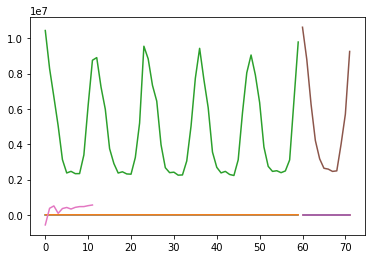

In [26]:
model = ARIMA(train_diff2, (2,2,2))
model_fit = model.fit()
full_forecast = model_fit.forecast(steps=test.shape[0])
forecast=pd.DataFrame(full_forecast[0])
plt.plot(train)
plt.plot(test)
plt.plot(forecast)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44277 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44553 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44277 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44553 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text

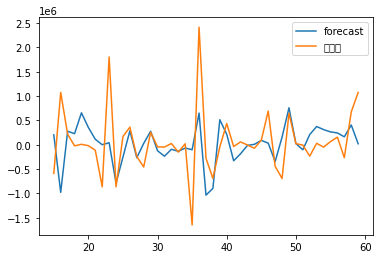

In [44]:
model_fit.plot_predict()
plt.show()

2018년의 데이터를 어떻게 예측할지 확인해보자.

In [50]:
fore = model_fit.forecast(steps=12)
fore  #(예측값, stderr, upperbd, lowerbd)


(array([-571474.08276131,  370048.45345937,  503935.56583716,
          85354.76668788,  356576.78245804,  416637.06838914,
         328252.47917698,  424140.22942506,  465322.89541528,
         467107.55612429,  518596.64882076,  556407.55396498]),
 array([525902.8571456 , 621853.20750787, 621863.36008557, 639158.09308694,
        644086.87445145, 644167.20382353, 646155.64300854, 646211.65785449,
        646422.17995608, 647065.71099053, 647227.53856247, 647616.60558663]),
 array([[-1602224.7421334 ,   459276.57661079],
        [ -848761.43692676,  1588858.3438455 ],
        [ -714894.22323562,  1722765.35490995],
        [-1167372.07618981,  1338081.60956557],
        [ -905810.29438176,  1618963.85929785],
        [ -845907.45112684,  1679181.58790513],
        [ -938189.30952708,  1594694.26788104],
        [ -842411.34635966,  1690691.80520978],
        [ -801641.2961065 ,  1732287.08693707],
        [ -801117.93304796,  1735333.04529654],
        [ -749946.01656419,  1787139.314